## Frequency-based Component Detection in Thermal Video

In this notebook, we will implement a computer vision pipeline to detect components within a thermal video that exhibit a specific frequency range of 0-1 Hz. These components may represent objects or phenomena with slow periodic motion, making them of interest in various applications.

In [1]:

import cv2
from IPython.display import display, clear_output
import PIL.Image
import ipywidgets as widgets

In [2]:

# Read the thermal video
cap = cv2.VideoCapture('1705951007967.mp4')

In [3]:
# Initialize background subtraction
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, detectShadows=False)

# Parameters for temporal filtering
alpha = 0.05
prev_frame = None

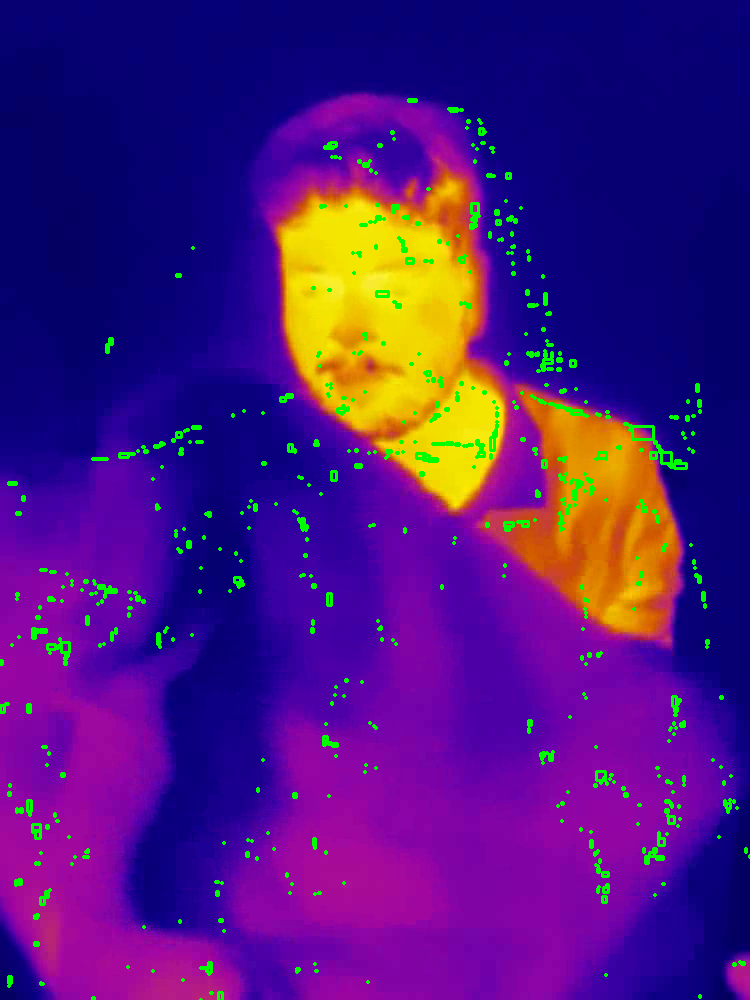

In [4]:
# Function to handle play button click
def play_video(b):
    global prev_frame  # Declare prev_frame as global variable
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply temporal filter
        if prev_frame is not None:
            filtered_frame = cv2.addWeighted(gray_frame, alpha, prev_frame, 1 - alpha, 0)
        else:
            filtered_frame = gray_frame.copy()

        # Update previous frame
        prev_frame = filtered_frame.copy()

        # Apply background subtraction
        fgmask = fgbg.apply(filtered_frame)

        # Threshold the foreground mask
        _, thresh = cv2.threshold(fgmask, 50, 255, cv2.THRESH_BINARY)

        # Find connected components
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)

        # Iterate through the connected components
        for i in range(1, num_labels):
            component_size = stats[i, cv2.CC_STAT_AREA]
            # Calculate frequency (assuming 30 FPS)
            frequency = component_size / 30.0
            # Filter components with frequency in the range 0-1 Hz
            if 0 <= frequency <= 1:
                # Draw bounding box around the component
                x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Display the resulting frame
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        display(PIL.Image.fromarray(frame_rgb))

        key = cv2.waitKey(30) & 0xFF
        if key == ord('q') or key == 27:  # Check for 'q' or 'Esc' key
            break

# Create and display the play button
play_button = widgets.Button(description='Play')
play_button.on_click(play_video)
display(play_button)
